In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [3]:
from exp import nb_anchors_loss_metrics_std
from exp import nb_resnet_ssd_std

In [4]:
import sys 
sys.path.append("..") 
from detect_symbol.exp import nb_databunch
from detect_symbol.exp import nb_resnet_ssd
from detect_symbol.exp import nb_anchors_loss_metrics

In [5]:
sys.path.append("../detect_symbol") 
from detect_symbol.exp import nb_interpretation

In [6]:
from detect_symbol.exp.nb_anchors_loss_metrics import get_y, idx_fromScoresHits

In [7]:
from detect_symbol.exp.nb_interpretation import draw_rect, draw_text, draw_outline

In [8]:
# export
import torch

In [9]:
# export
from torch import tensor

In [10]:
from fastai.basic_train import Learner

In [11]:
# export
from matplotlib import pyplot as plt

In [12]:
# export
from matplotlib import patches,patheffects

In [13]:
# export
from IPython.core import debugger as idb

In [14]:
from fastai.vision.image import Image

In [15]:
from functools import partial

In [16]:
# export
from math import ceil

# functions

### show_gt

In [17]:
def show_gt(x,y):
    img = data.denorm(x)[0].permute(1,2,0)

    _,ax = plt.subplots(1,1,figsize=(15,15))
    ax.imshow(img)
    
    for bb,cat in zip(y[0][0],y[1][0]):
        bb = (bb+1)/2*776
        draw_rect(ax,bb,lw=1)
        
        cat = cat-1
        clas = classes[cat]
        draw_text(ax,bb[[3,0]],clas[:3],sz=10)

### show_gt_anchors

In [18]:
def show_gt_anchors(x,y,device,n=10):
    '根据ground truch找到负责idxs，绘制这些idxs对应的anchor'
    _,ax = plt.subplots(1,1,figsize=(20,20))
    img = data.denorm(x)[0].permute(1,2,0)
    ax.imshow(img)
    #import pdb; pdb.set_trace()    
    idxs = idx_from_gt(*y,gaf=gaf)
    for idx in idxs:
        gv = gvs[idx]*x.shape[-1]
        draw_rect(ax,gv,lw=1,color='g')
        
        cx = gv[[0,2]].mean()
        cy = gv[[1,3]].mean()
        
        av = avs[idx]*x.shape[-1]
        av = av+tensor([cx,cy,cx,cy]).to(device)
        draw_rect(ax,av,lw=1)
        

        draw_text(ax,av[[3,0]],f'{idx}',sz=10)
    return idxs

###  idx_from_gt

In [19]:
def idx_from_gt(*gt_batch, gaf):
    loss = 0
    cnt = 0
    for gt_bboxs in gt_batch[0]:
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        gt_bboxs = gt_bboxs[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        return idx

In [20]:
def process_netout_std(txys,cats,confs,gaf):
    ts = torch.cat([txys],dim=-1)
    ts2 = torch.cat([txys,txys],dim=-1)
    ts.device
    boxs = gaf.t2b(ts, torch.arange(start = 0, end = ts.shape[-2], device=ts.device))
    
    confs = torch.sigmoid(confs).squeeze(-1)
    prbs,cats = torch.softmax(cats,dim=-1).max(dim=-1)
#     cats = cats + 1
    
    return boxs,confs,cats,prbs

In [21]:
def netouts2preds_std(batchOut,gaf,composeConfPrb=True,filt_thres=0.9,ov_thres=0.2,despiteCat=True):
    '''
    处理一个batch
    '''
    batch_boxs = []
    batch_confs = []
    batch_cats = []
    batch_prbs = []
    batch_f1s = []
    
    for txys,confs,cats in zip(batchOut[0].detach(),batchOut[1].detach(),batchOut[2].detach()):
        boxs,confs,cats,prbs = process_netout_std(txys,cats,confs,gaf)
        
        f1s = 2*confs*prbs/(confs+prbs)
        if composeConfPrb:
            filt = torch.where(f1s>filt_thres)
        else:
            filt = torch.where(confs>filt_thres)
            
        boxs = boxs[filt]
        confs = confs[filt]
        cats = cats[filt]
        prbs = prbs[filt]
        f1s = f1s[filt]
        
        '''
        没有宽高。所以根本不需要nms
        if composeConfPrb:
            keep,cnt = nb_interpretation.nms(boxs, cats, f1s, ov_thres=ov_thres, despiteCat=True)
        else:
            keep,cnt = nb_interpretation.nms(boxs, cats, confs, ov_thres=ov_thres, despiteCat=True)            
        keep = keep[:cnt].long()        
        boxs = boxs[keep]
        confs = confs[keep]
        cats = cats[keep]
        prbs = prbs[keep]
        f1s = f1s[keep]
        '''
        
        batch_boxs += [boxs]
        batch_confs += [confs]
        batch_cats += [cats]
        batch_prbs += [prbs]
        batch_f1s += [f1s]
        
    return batch_boxs, batch_confs, batch_cats, batch_prbs, batch_f1s

In [247]:
def show_top_pred(x,netOut,n=10, NMS = True, TH = 0.9, bidx = 0):
    '''
    根据模型输出，处理得到boxs和confs，按照confs从大到小排序，绘制前n个的box.
    x的作用仅是为绘制原图；
    '''
    BY_PRB = False
    _,ax = plt.subplots(1,1,figsize=(20,20))
    img = data.denorm(x)[bidx].permute(1,2,0)
    ax.imshow(img)
    
    txys,confs,cats = netOut[0][bidx].detach(),netOut[1][bidx].detach(),netOut[2][bidx].detach()
    boxs,confs,cats,prbs = process_netout_std(txys,cats,confs,gaf)
    #转换到点
    boxs = boxs * x.shape[-1]
    
    if NMS:
        boxs[:,2] += 16.0  #776/49
        boxs[:,3] += 16.0
        keep,cnt = nb_interpretation.nms(boxs, cats, confs, ov_thres=0.2, despiteCat=True)            
        keep = keep[:n].long()        
        boxs = boxs[keep]
        confs = confs[keep]
        cats = cats[keep]
        prbs = prbs[keep]
    
    top_idx = confs.sort(descending=True)[1]
    if BY_PRB:
        top_idx = prbs.sort(descending=True)[1]
    
    for idx in top_idx[:n]:
        if confs[idx] < TH:
            continue
        #bb = boxs[idx]*x.shape[-1]
        bb = boxs[idx]
        #draw_rect(ax,bb,lw=1)
        w, h = 16, 16
        lw = 1
        patch = ax.add_patch(patches.Rectangle((bb[1],bb[0]), w, h
                    , fill=False, edgecolor='green', lw=lw))
        draw_outline(patch, lw=lw)

        clas = classes[cats[idx]]
        conf = confs[idx]
        prb = prbs[idx]
        info = '{}_{}_{:.2f}'.format(idx,clas[:3],conf*100)
        if BY_PRB:
            info = '{}_{}_{:.2f}'.format(idx,clas[:3],prb*100)
        draw_text(ax,bb[[3,0]],info,sz=10)
        print(info, bb)
    return top_idx[:n]

# test

## 准备好learner

In [71]:
device = torch.device('cuda', 1)

In [72]:
device_ids = [1]

In [258]:
#先用detect_symbol的数据集测试
data = nb_databunch.get_databunch(data_root = '../detect_symbol/data/ds_20200429', bs=8, device=device)
x,y = data.one_batch()

In [74]:
gaf = nb_anchors_loss_metrics_std.GridAnchor_Funcs_std(fig_hw = (776,776)
                         , grids = [(49,49)]
                         , device = device)
gvs, avs = gaf.gvs, gaf.avs

In [175]:
model = nb_resnet_ssd_std.get_resnet18_1ssd_std(num_classes = 17)

In [186]:
#fn = '../detect_symbol_bak20200427/data/ds_20200227/models/run_0.pth'
fn = '/home/dev/jupyter/detect_symbol/data/ds_20200429/models/run_0.pth'
#fn = './models/resnet18_1ssd_init.pth'
stat = torch.load(fn)

In [ ]:
for n, p in model.named_parameters():
    print(n, p.shape, p.sum().cpu().detach().numpy(), stat['model'][n].sum().cpu().detach().numpy())
    #print(n, p.shape)
    p = stat['model'][n]
    print(p.sum().cpu().detach().numpy())

In [188]:
learn = Learner(data,model)

In [189]:
# 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
if hasattr(learn.model, "module"): 
    learn.model = model.module

learn.model.to(device);

if device.type=='cuda':
    learn.model = torch.nn.DataParallel(model,device_ids=device_ids)

In [190]:
learn.model.eval();

## 看这个网络的效果和之前的符号检测网络的效果对比

### 完全随机的状态

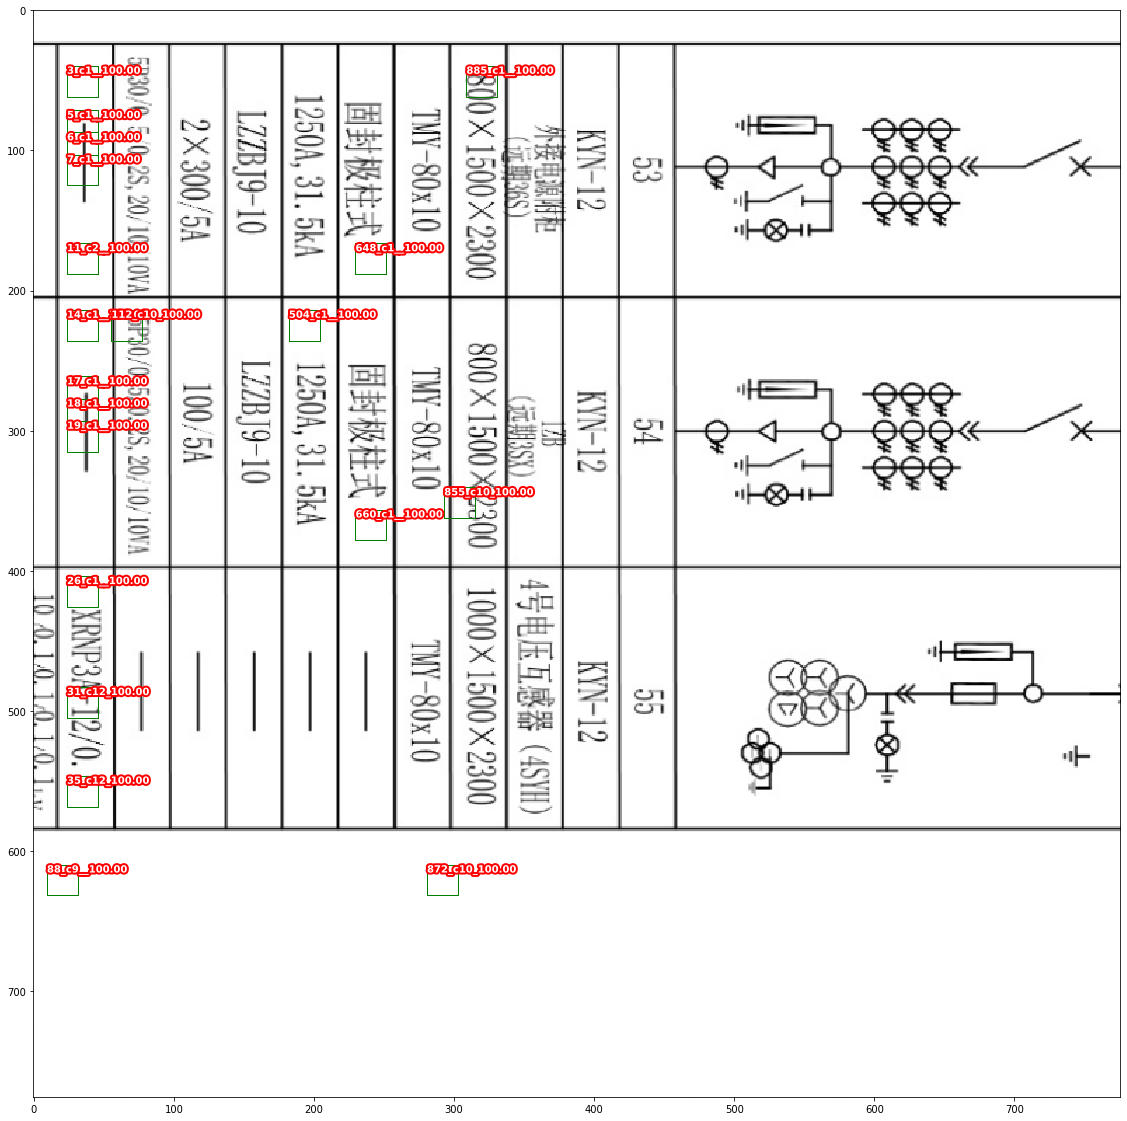

In [214]:
if True:
    model = nb_resnet_ssd_std.get_resnet18_1ssd_std(num_classes = 17)
    learn = Learner(data,model)
    # 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
    if hasattr(learn.model, "module"): 
        learn.model = model.module
    learn.model.to(device);
    if device.type=='cuda':
        learn.model = torch.nn.DataParallel(model,device_ids=device_ids)
    learn.model.eval();
    
    out = learn.model(x)
    top_idx=show_top_pred(x,out,20)

### 用训练的结果看看

In [268]:
bidx = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1_c12_100.00 tensor([117.3924, 603.6719, 133.3924, 619.6719], device='cuda:1')
0_c12_100.00 tensor([116.1491, 318.4035, 132.1491, 334.4035], device='cuda:1')
2_c17_100.00 tensor([186.3361,  61.0846, 202.3361,  77.0845], device='cuda:1')
3_c5__100.00 tensor([ 92.7618,  80.4303, 108.7618,  96.4303], device='cuda:1')
4_c2__100.00 tensor([ 59.5059, 267.1324,  75.5059, 283.1324], device='cuda:1')
5_c14_100.00 tensor([ 91.6613, 108.2872, 107.6613, 124.2872], device='cuda:1')
6_c2__100.00 tensor([ 60.7638, 552.6016,  76.7638, 568.6016], device='cuda:1')
7_c7__100.00 tensor([101.6706,  28.6524, 117.6706,  44.6524], device='cuda:1')


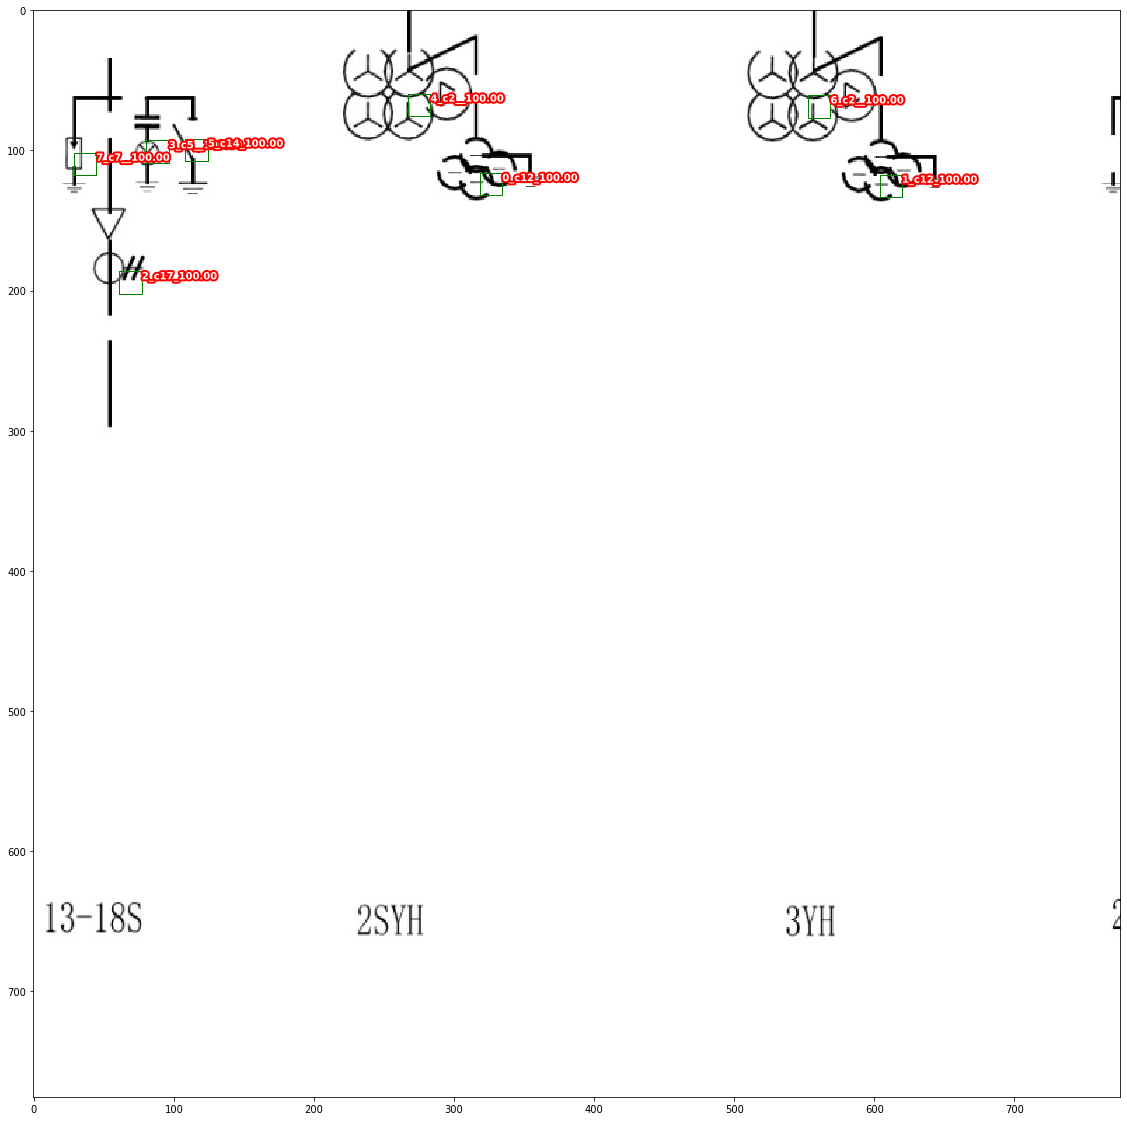

In [269]:
if True:
    device = torch.device('cuda', 1)
    model = nb_resnet_ssd_std.get_resnet18_1ssd_std(num_classes = 17)
    learn = Learner(data,model)
    gaf = nb_anchors_loss_metrics_std.GridAnchor_Funcs_std(fig_hw = (776,776)
                         , grids = [(49,49)]
                         , device = device)
    gvs, avs = gaf.gvs, gaf.avs
    
    fn = '/home/dev/jupyter/detect_symbol/data/ds_20200429/models/run_0.pth'
    with open(fn,'rb') as f:
        learn.load(f)
#     for n, p in learn.model.named_parameters():
#         print(n, p.shape, p.sum().cpu().detach().numpy(), stat['model'][n].sum().cpu().detach().numpy())
#         #print(n, p.shape)
#         p = stat['model'][n]
#         print(p.sum().cpu().detach().numpy())
    
    # 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
    if hasattr(learn.model, "module"): 
        learn.model = model.module
    learn.model.to(device);
    if device.type=='cuda':
        learn.model = torch.nn.DataParallel(model,device_ids=device_ids)
    learn.model.eval();
    
    out = learn.model(x)
    #import pdb; pdb.set_trace()    
    top_idx=show_top_pred(x,out,60, bidx = bidx)
    


## 用之前的detect_symbol的结果对比一下

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


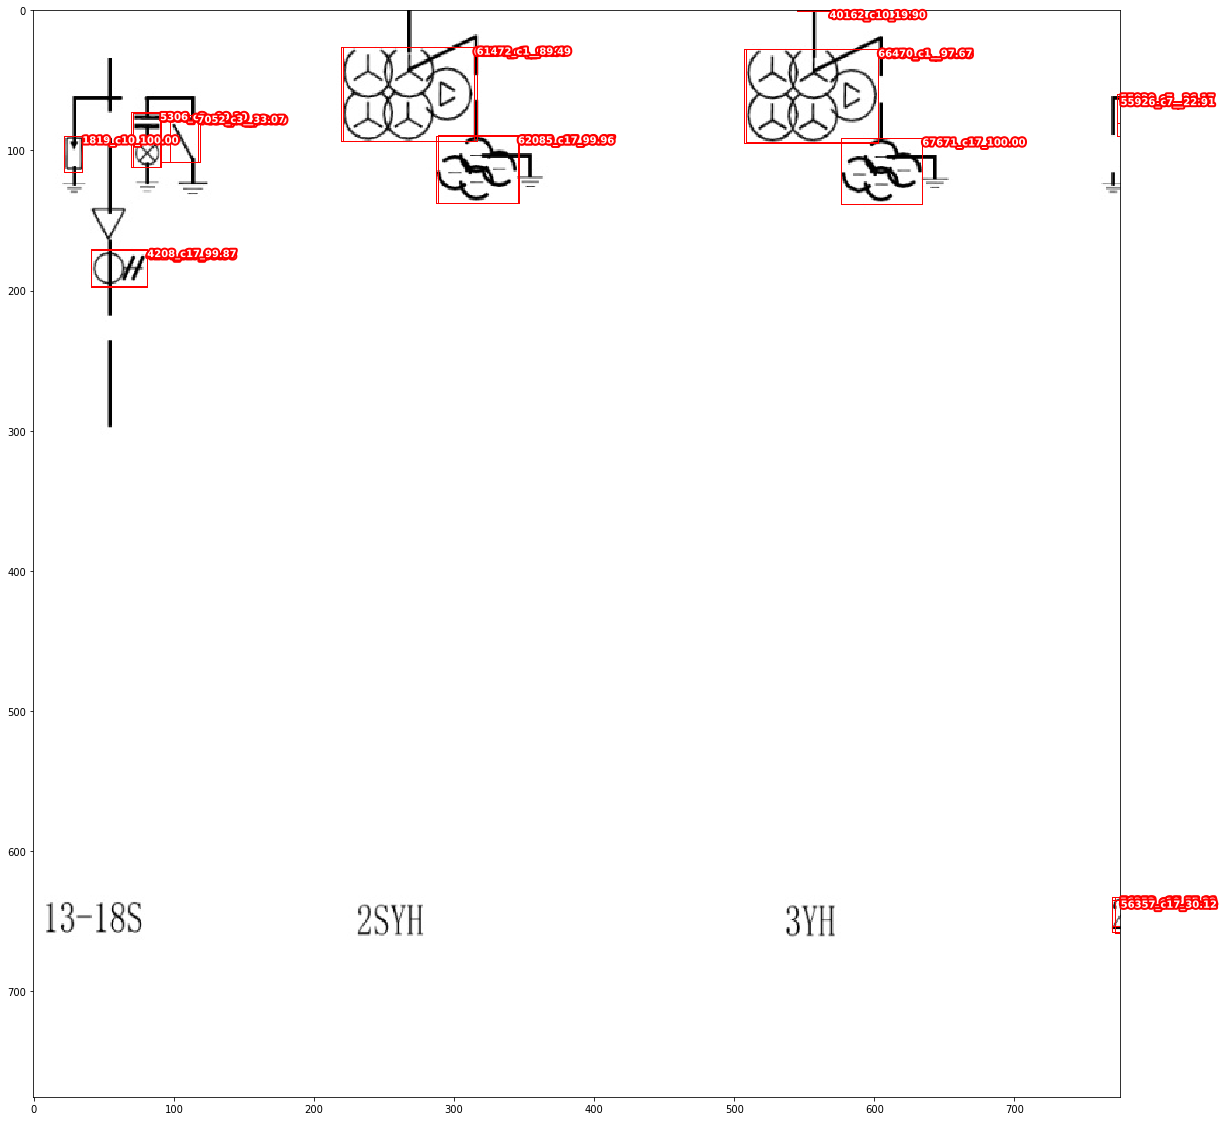

In [270]:
def show_top_pred_ds(x,netOut,n=10,bidx = 0):
    '''
    根据模型输出，处理得到boxs和confs，按照confs从大到小排序，绘制前n个的box.
    x的作用仅是为绘制原图；
    '''
    _,ax = plt.subplots(1,1,figsize=(20,20))
    img = data.denorm(x)[bidx].permute(1,2,0)
    ax.imshow(img)
    
    txys,confs,cats,thws = netOut[0][bidx].detach(),netOut[1][bidx].detach(),netOut[2][0].detach(),netOut[3][bidx].detach() 
    boxs,confs,cats,prbs = nb_interpretation.process_netout(txys,thws,cats,confs,gaf)
    
    top_idx = confs.sort(descending=True)[1]
    for idx in top_idx[:n]:
        bb = boxs[idx]*x.shape[-1]
        draw_rect(ax,bb,lw=1)

        clas = classes[cats[idx]]
        conf = confs[idx]
        info = '{}_{}_{:.2f}'.format(idx,clas[:3],conf*100)
        draw_text(ax,bb[[3,0]],info,sz=10)
    return top_idx[:n]

if True:
    device = torch.device('cuda', 0)
    gvs,_,_,avs,_,_ = nb_anchors_loss_metrics.get_ga666()
    gaf = nb_anchors_loss_metrics.GridAnchor_Funcs(gvs,avs,device)
    model = nb_resnet_ssd.get_resnet34_1ssd()
    learn = Learner(data,model)
    with open('../detect_symbol/run_log/20200429/run_0.pth','rb') as f:
        learn.load(f)
    if hasattr(learn.model, "module"): 
        learn.model = model.module
    learn.model.to(device);
    if device.type=='cuda':
        learn.model = torch.nn.DataParallel(model,device_ids=[0])
    learn.model.eval();
    netOut = learn.model(x)
    top_idx=show_top_pred_ds(x,netOut,20,bidx=bidx)

## 验证模型的整体表现

In [179]:
metrics = [partial(nb_anchors_loss_metrics.clas_L,gaf=gaf),
           partial(nb_anchors_loss_metrics.cent_L,gaf=gaf),
           partial(nb_anchors_loss_metrics.pConf_L,gaf=gaf),
           partial(nb_anchors_loss_metrics.nConf_L,gaf=gaf),
           partial(nb_anchors_loss_metrics.clas_acc,gaf=gaf),
           partial(nb_anchors_loss_metrics_std.cent_d_std,gaf=gaf)]

learn.loss_func = partial(nb_anchors_loss_metrics_std.yolo_L_std, gaf=gaf)

res = learn.validate(data.train_dl,metrics=metrics)

res

KeyboardInterrupt: 

## 观察

In [180]:
classes = data.train_ds.y.classes[1:]
classes

['c10_duanluqi',
 'c11_sanxiangbyq',
 'c12_dongrongshidyhgq',
 'c13_danxiangbyq',
 'c14_danciranzudlhgq',
 'c15_duojikaiguan',
 'c16_diankangqi',
 'c17_8_dianliuhuganqi',
 'c1_tiaoya',
 'c2_dianyahgq',
 'c3_3gongweiglkg',
 'c4_kuaisujdkg',
 'c5_daidianxianshiqi',
 'c6_rongduanqi',
 'c7_bileiqi',
 'c8_dianliuhgq',
 'c9_danxiangdyhgq']

In [ ]:
x,y = next(iter(data.valid_dl))
show_gt(x,y)

In [125]:
#show_gt_anchors(x,y, device)

In [191]:
out = learn.model(x)

In [192]:
out[0].shape, out[1].shape, out[2].shape

(torch.Size([4, 2401, 2]), torch.Size([4, 2401, 1]), torch.Size([4, 2401, 17]))

In [193]:
out[1][0][1]

tensor([41.5122], device='cuda:1', grad_fn=<SelectBackward>)

In [271]:
def dbg():    
    import pdb; pdb.set_trace()    
    #pout = nb_interpretation.process_netout(out[0].detach(), out[0].detach(), out[2].detach(), out[1].detach(), gaf)
    top_idx=show_top_pred(x,out,20)
#dbg()    

In [ ]:
top_idx=show_top_pred(x,out,20)

In [111]:
top_idx

tensor([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27], device='cuda:1')

In [69]:
top_idx.shape

torch.Size([120])

In [ ]:
batch_x = [data.denorm(xx) for xx in x]
nb_interpretation.show_batch_pred(batch_x, out[0], out[2], out[1], data.classes)

In [113]:
import pandas as pd

In [ ]:
#看看训练曲线
df = pd.read_csv('../detect_symbol/data/ds_20200429/csv_log/run_0.csv')
print(df)
plt.plot(df.train_loss)

#plt.ylim((0.,0.1))    
plt.xlabel('iteration')    
plt.ylabel('mask_iou')

plt.legend()
plt.show()            
#df           

In [ ]:
def dbg():    
    import pdb; pdb.set_trace()    
    pout = process_netout(out[0].detach(), out[2].detach(), out[1].detach(), gaf)

pout = dbg()  

In [ ]:
pout = process_netout(out[0].detach(), out[2].detach(), out[1].detach(), gaf)

In [ ]:
pout[0].shape,pout[1].shape,pout[2].shape,pout[3].shape

In [ ]:
TH = 0.98

In [ ]:
torch.where(pout[1] > TH)[0].shape

In [ ]:
filt = torch.where(pout[1] > TH)

In [ ]:
boxs, confs, cats, prbs = pout[0], pout[1], pout[2], pout[3]

In [ ]:
cats.shape

In [ ]:
boxs = boxs[filt]

In [ ]:
confs = confs[filt]

In [ ]:
torch.min(confs)

In [ ]:
#pout = nb_interpretation.process_netout(out[0].detach(), [], out[2].detach(), out[1].detach(), gaf)

# export

In [ ]:
!python notebook2script.py --fname 'interpretation_std.ipynb' --outputDir './exp/'